In [26]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('./round-4-island-data-bottle/prices_round_4_day_1.csv', delimiter=';')

# Display the first few rows of the DataFrame
df.head()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,1,0,VOLCANIC_ROCK,10515.0,143.0,10514.0,57.0,NaN,NaN,10517,200,NaN,NaN,NaN,NaN,10516.0,0.0
1,1,0,PICNIC_BASKET1,58705.0,12.0,58704.0,27.0,NaN,NaN,58716,12,58717.0,27.0,NaN,NaN,58710.5,0.0
2,1,0,PICNIC_BASKET2,30252.0,12.0,30251.0,27.0,NaN,NaN,30258,39,NaN,NaN,NaN,NaN,30255.0,0.0
3,1,0,VOLCANIC_ROCK_VOUCHER_9500,1015.0,12.0,NaN,NaN,NaN,NaN,1017,12,NaN,NaN,NaN,NaN,1016.0,0.0
4,1,0,VOLCANIC_ROCK_VOUCHER_9750,766.0,12.0,NaN,NaN,NaN,NaN,767,12,NaN,NaN,NaN,NaN,766.5,0.0


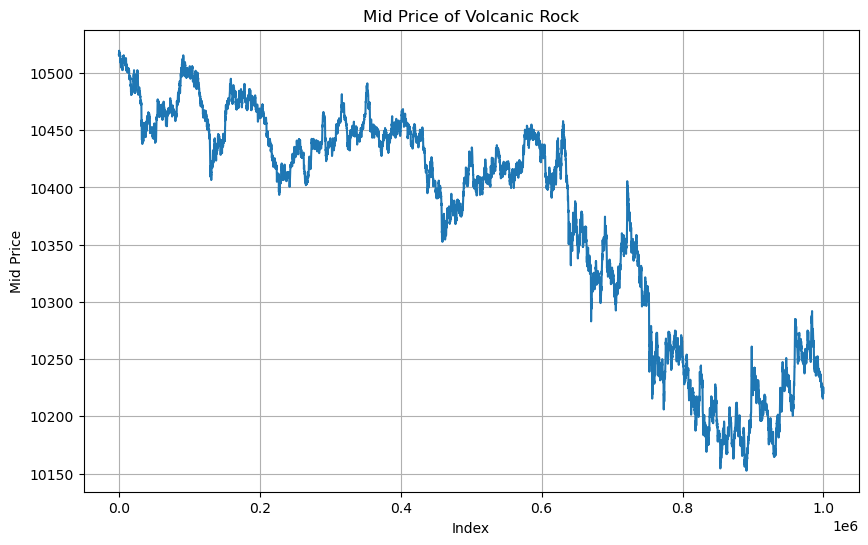

In [20]:
import matplotlib.pyplot as plt

# Filter the DataFrame for the desired rows and select the 'mid_price' column.
volcanic_mid_price = df[df['product'] == 'VOLCANIC_ROCK']

# Plot the data.
plt.figure(figsize=(10, 6))
plt.plot(volcanic_mid_price['timestamp'],volcanic_mid_price['mid_price'])  # Added marker for better visibility
plt.title("Mid Price of Volcanic Rock")
plt.xlabel("Index")
plt.ylabel("Mid Price")
plt.grid(True)
plt.show()

In [36]:
df_all = df
df_all.head()
df_all.set_index('timestamp', inplace=True)

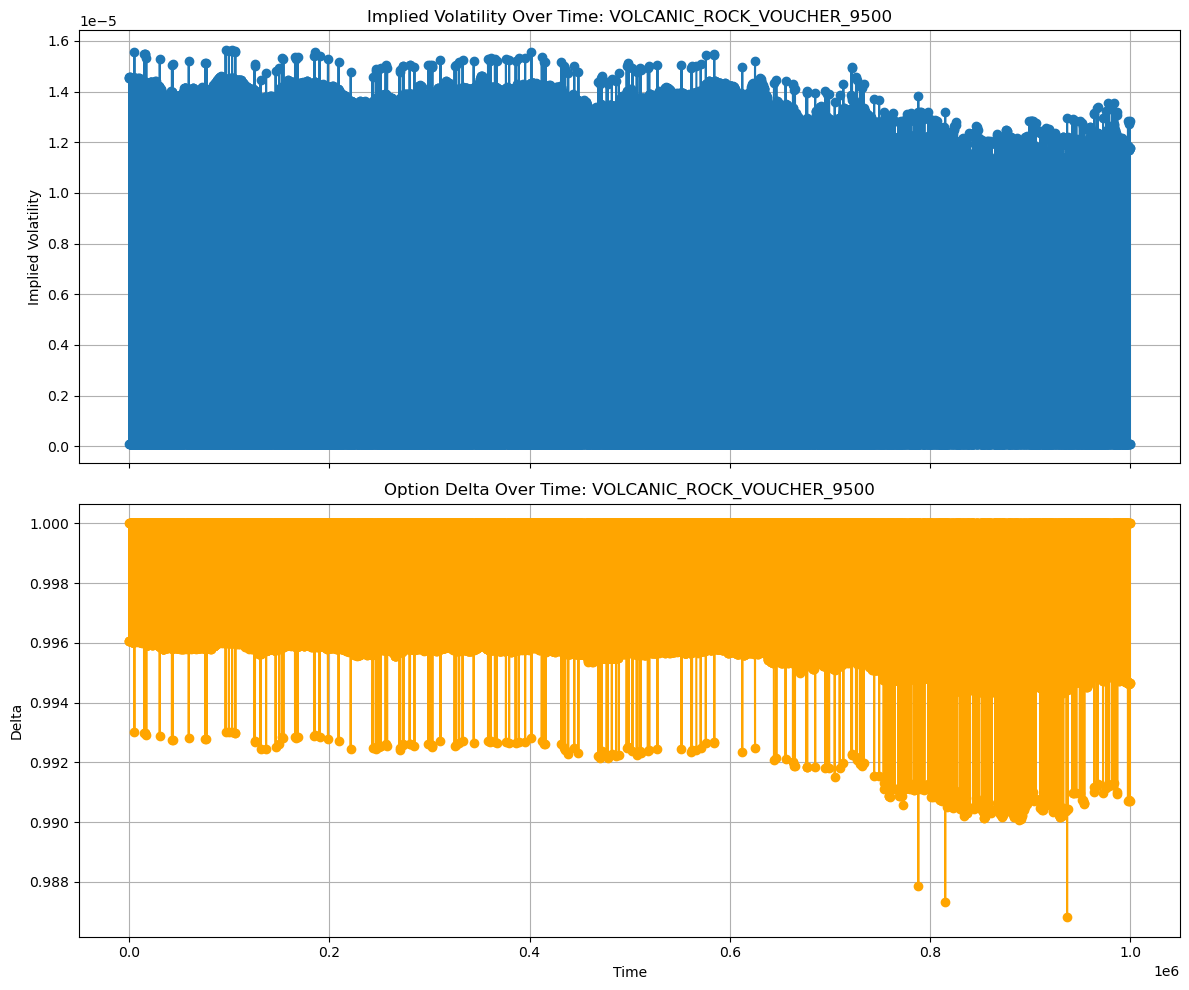

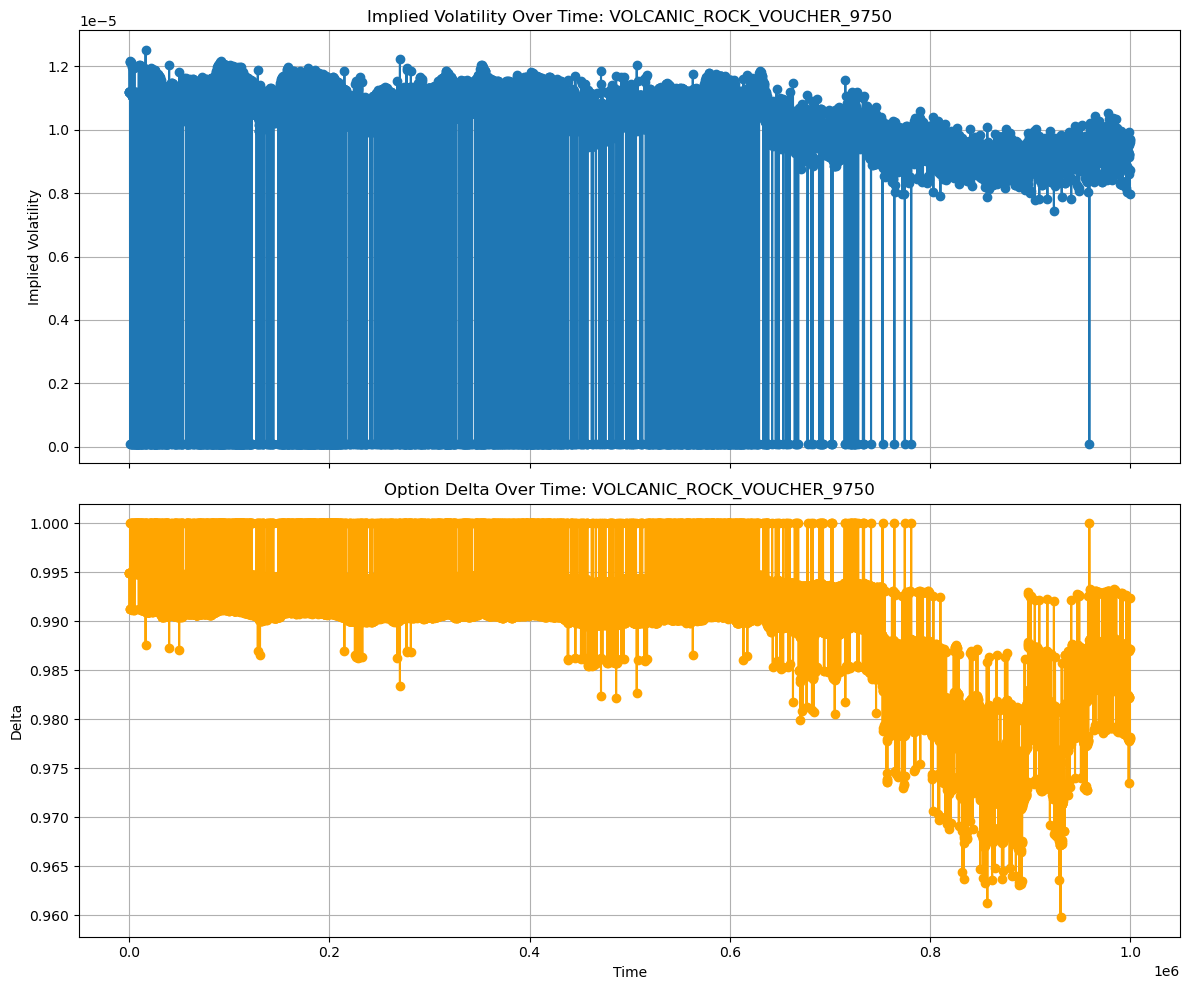

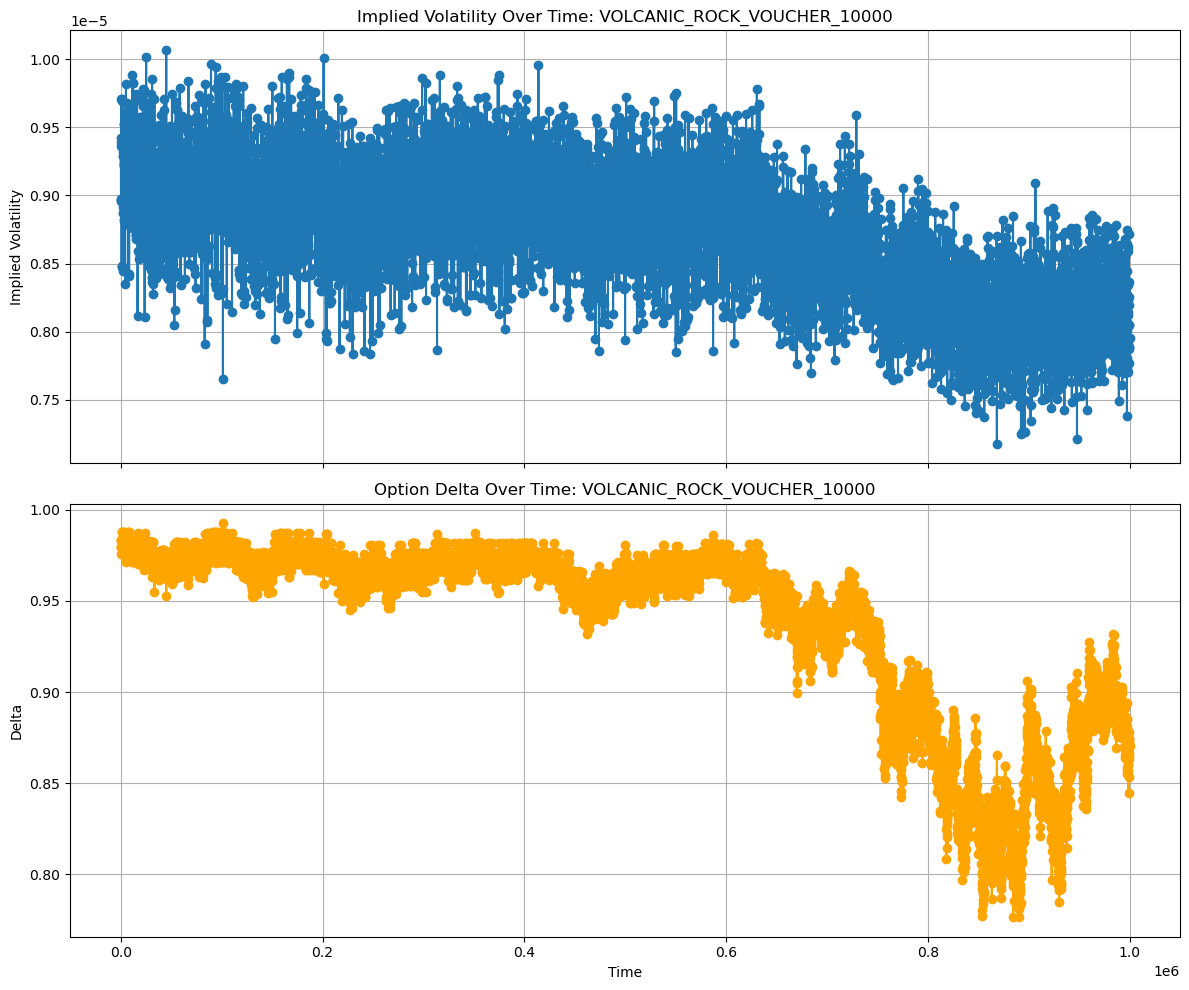

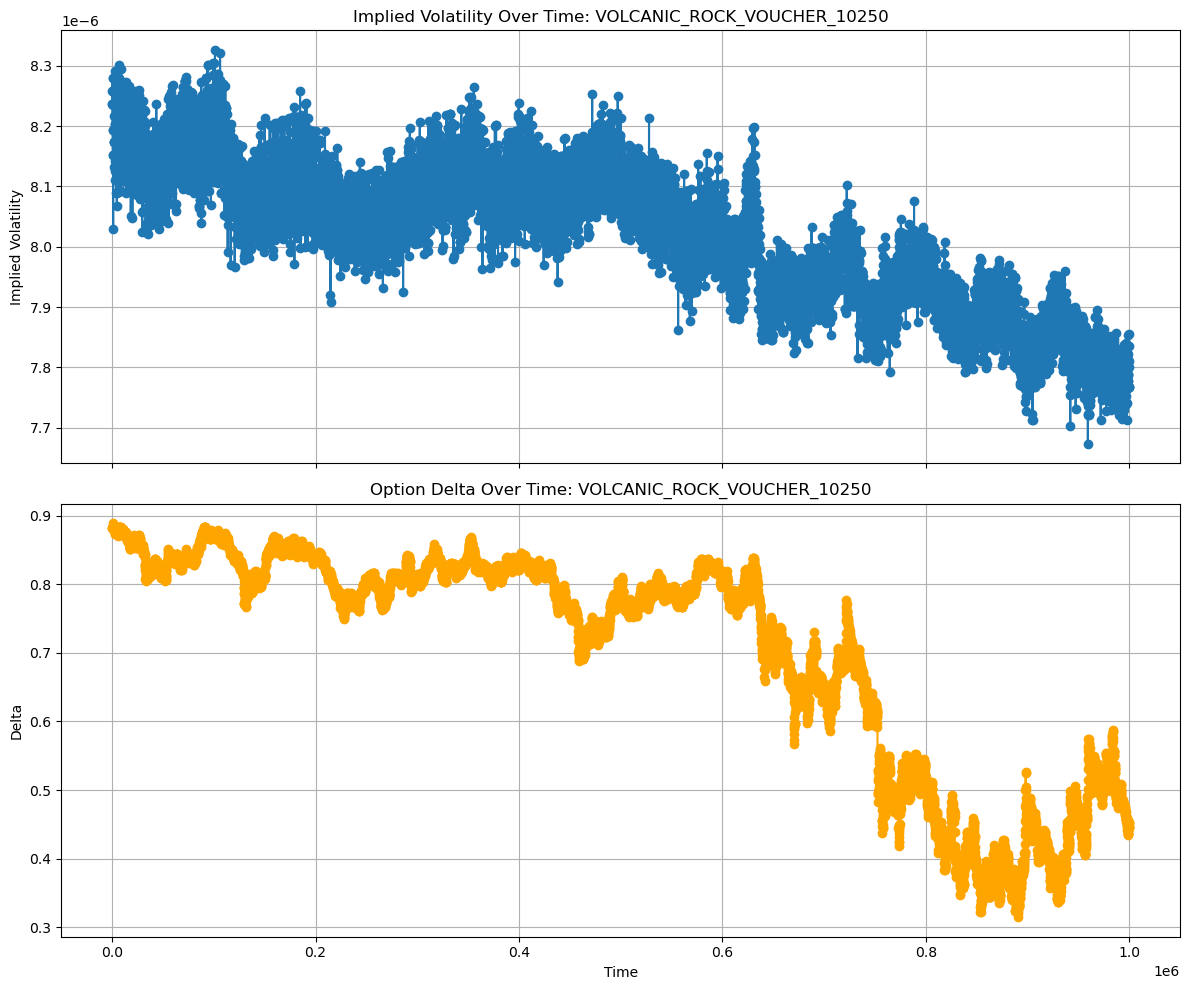

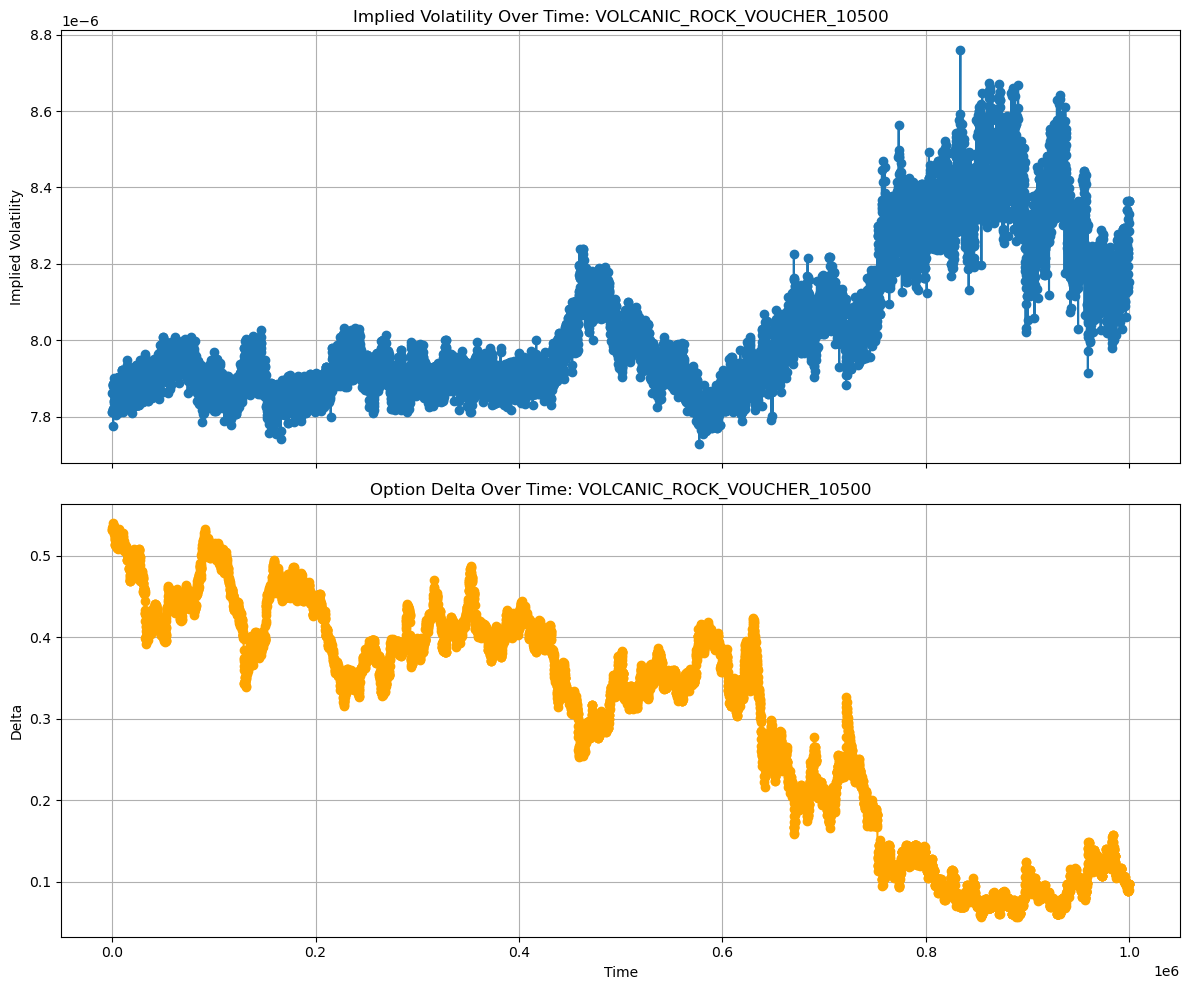

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq

# Black-Scholes call option pricing function.
def bs_call_price(S, K, T, r, sigma):
    """
    Compute the Black-Scholes price for a European call option.
    
    Parameters:
      S: underlying price
      K: strike price
      T: time to maturity (in years)
      r: risk-free interest rate (annualized)
      sigma: volatility (annualized)
    
    Returns:
      call option price
    """
    if T <= 0:
        # Option has expired.
        return max(S - K, 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Function to calculate implied volatility via numerical inversion.
def implied_vol(S, K, T, r, market_price, tol=1e-7):
    """
    Compute the implied volatility using numerical inversion of the Black-Scholes formula.
    
    Parameters:
      S: underlying price
      K: strike price
      T: time to maturity (in years)
      r: risk-free interest rate (annualized)
      market_price: observed market price of the option
      tol: tolerance for the numerical solver
    
    Returns:
      implied volatility (sigma) or np.nan if unable to solve.
    """
    def objective(sigma):
        return bs_call_price(S, K, T, r, sigma) - market_price

    try:
        implied_sigma = brentq(objective, 1e-7, 1e-4, xtol=tol)
    except ValueError:
        implied_sigma = np.nan
    return implied_sigma

# Function to compute the option delta.
def call_delta(S, K, T, r, sigma):
    """
    Compute the call option delta (using N(d1)) from the Black-Scholes formula.
    
    Parameters:
      S: underlying price
      K: strike price
      T: time to maturity (in years)
      r: risk-free interest rate (annualized)
      sigma: volatility (annualized)
    
    Returns:
      option delta.
    """
    if T <= 0 or sigma == 0:
        return 1.0 if S > K else 0.0
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

# Assumptions / Parameters
# List of voucher products along with their strike prices.
vouchers = [
    ('VOLCANIC_ROCK_VOUCHER_9500', 9500),
    ('VOLCANIC_ROCK_VOUCHER_9750', 9750),
    ('VOLCANIC_ROCK_VOUCHER_10000', 10000),
    ('VOLCANIC_ROCK_VOUCHER_10250', 10250),
    ('VOLCANIC_ROCK_VOUCHER_10500', 10500)
]
r = 0.00   # Annualized risk-free interest rate (adjust if needed)

# Set maturity to 7 days from now (using your convention).
maturity_date = df_all.index[0] + 10000 * 100 * 7

# Extract underlying prices.
underlying = df_all[df_all['product'] == 'VOLCANIC_ROCK']['mid_price']

# Loop through each voucher and compute IV and delta.
for product, K in vouchers:
    option = df_all[df_all['product'] == product]['mid_price']
    
    # Combine underlying and option mid prices into a single DataFrame.
    data = pd.DataFrame({
        'underlying': underlying,
        'option': option  # This is the observed mid_price for the option.
    }).dropna()
    
    # Compute time to maturity (in years) for each observation.
    # Ensure that T is in years if Black-Scholes expects annualized volatility.
    # If your time unit is not in years, adjust the conversion accordingly.
    data['time_to_maturity'] = (maturity_date - data.index) 
    data = data[data['time_to_maturity'] > 0]
    
    # Lists to store computed implied volatility and delta.
    iv_list = []
    delta_list = []
    
    # Loop through each observation to compute IV and delta.
    for idx, row in data.iterrows():
        S = row['underlying']
        market_price = row['option']
        T = row['time_to_maturity']
        
        sigma_imp = implied_vol(S, K, T, r, market_price)
        iv_list.append(sigma_imp)
        
        if np.isnan(sigma_imp):
            delta_list.append(np.nan)
        else:
            delta_list.append(call_delta(S, K, T, r, sigma_imp))
    
    data['implied_vol'] = iv_list
    data['delta'] = delta_list
    
    # Save the mid_price as a separate column.
    data['mid_price'] = data['option']
    
    # --- Save the DataFrame to a CSV file ---
    output_filename = f"{product}_iv_delta_record.csv"
    data.to_csv(output_filename)
    
    # --- Plotting Results for this voucher ---
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # Plot Implied Volatility.
    axes[0].plot(data.index, data['implied_vol'], marker='o', linestyle='-')
    axes[0].set_title(f'Implied Volatility Over Time: {product}')
    axes[0].set_ylabel('Implied Volatility')
    axes[0].grid(True)

    # Plot Option Delta.
    axes[1].plot(data.index, data['delta'], marker='o', linestyle='-', color='orange')
    axes[1].set_title(f'Option Delta Over Time: {product}')
    axes[1].set_ylabel('Delta')
    axes[1].set_xlabel('Time')
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, SelectionSlider

# --- 1. Data Loading and Preprocessing ---

# List of products (vouchers).
selected_products = [
    'VOLCANIC_ROCK_VOUCHER_9500',
    'VOLCANIC_ROCK_VOUCHER_9750',
    'VOLCANIC_ROCK_VOUCHER_10000',
    'VOLCANIC_ROCK_VOUCHER_10250',
    'VOLCANIC_ROCK_VOUCHER_10500'
]

# Load and filter data for each voucher.
# Rows with NaN in key columns or where delta==0 or implied_vol==1e-07 are dropped.
product_data = {}
for product in selected_products:
    filename = f"{product}_iv_delta_record.csv"
    df = pd.read_csv(filename, index_col=0, parse_dates=False)
    df = df.dropna(subset=["implied_vol", "delta", "mid_price", "time_to_maturity"])
    df = df[(df['delta'] != 0) & (df['implied_vol'] != 1e-07)]
    # Convert the index (time) to numeric.
    df.index = pd.to_numeric(df.index)
    product_data[product] = df

# Determine common timestamps present in every voucher.
common_times = None
for df in product_data.values():
    unique_times = set(df.index.unique())
    if common_times is None:
        common_times = unique_times
    else:
        common_times = common_times.intersection(unique_times)
common_times = sorted(list(common_times))

# Optionally, skip some timestamps to reduce clutter.
skip_factor = 2  # For example, take every 2nd timestamp.
common_times = common_times[::skip_factor]

# Restrict each voucher's dataframe to only the common timestamps.
for product in product_data:
    product_data[product] = product_data[product].loc[product_data[product].index.isin(common_times)]

# --- 2. Global Parabolic Fit at Each Timestamp with Vertex at m_t=0 ---
# At each common timestamp, we aggregate one representative (m_t, iv) pair for each voucher.
# m_t is defined by:
#    m_t = log(K / S_t) / sqrt(time_to_maturity)
# To force the vertex at m_t = 0, we fit:
#    iv(m_t) = a * m_t^2 + c,
# using a linear least squares fit on m_t^2 and a constant term.
global_fit = {}  # Key: timestamp, value: dict with aggregated 'x', 'y', 'coeffs', 'poly', and 'base_volatility'
global_base_vol_evolution = []  # Base volatility evolution over time

for ts in common_times:
    X_list = []
    Y_list = []
    for product in selected_products:
        # Extract the strike from the product name.
        strike = float(product.split('_')[-1])
        df_ts = product_data[product].loc[product_data[product].index == ts]
        if df_ts.empty:
            continue
        # Compute m_t values for each row and take the mean as the representative value.
        m_t_vals = np.log(strike / df_ts["underlying"]) / np.sqrt(df_ts["time_to_maturity"])
        m_t_rep = m_t_vals.mean()
        iv_rep = df_ts["implied_vol"].mean()
        X_list.append(m_t_rep)
        Y_list.append(iv_rep)
    
    X_arr = np.array(X_list)
    Y_arr = np.array(Y_list)
    
    if len(X_arr) < 3:
        global_fit[ts] = None
        global_base_vol_evolution.append(np.nan)
    else:
        # Prepare design matrix with m_t^2 and a constant.
        M = np.vstack([X_arr**2, np.ones(len(X_arr))]).T
        # Least squares solution [a, c] minimizing ||a*m_t^2 + c - iv||^2.
        coeffs, _, _, _ = np.linalg.lstsq(M, Y_arr, rcond=None)
        # In our model, coeffs[0]=a and coeffs[1]=c (base volatility).
        a, c = coeffs
        # Create a poly1d object for consistency.
        poly = np.poly1d([a, 0, c])
        base_volatility = c  # iv(0) = c
        
        global_fit[ts] = {
            'x': X_arr,
            'y': Y_arr,
            'coeffs': coeffs,  # [a, c]
            'poly': poly,
            'base_volatility': base_volatility,
            'x_min': X_arr.min(),
            'x_max': X_arr.max()
        }
        global_base_vol_evolution.append(base_volatility)

# --- 3. Interactive Plotting ---

def update_plot(time_value):
    fig, (ax_top, ax_bottom) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Top Subplot: Plot aggregated data and the constrained fitted parabola for the selected timestamp.
    data = global_fit.get(time_value, None)
    if data is None:
        ax_top.text(0.5, 0.5, "Not enough data to fit a parabola at this time", 
                    transform=ax_top.transAxes, ha='center', va='center', fontsize=14, color='red')
    else:
        X_arr, Y_arr = data['x'], data['y']
        coeffs = data['coeffs']
        poly = data['poly']
        base_vol = data['base_volatility']
        
        # Plot raw aggregated data points.
        ax_top.plot(X_arr, Y_arr, 'o', label='Aggregated Data')
        
        # Create a smooth curve over an extended range.
        x_fit = np.linspace(data['x_min'] * 0.95, data['x_max'] * 1.05, 100)
        y_fit = poly(x_fit)
        ax_top.plot(x_fit, y_fit, '-', label='Constrained Parabolic Fit')
        
        # Mark the base volatility at m_t = 0.
        ax_top.plot(0, base_vol, 'rd', markersize=10, label='Base Volatility (m_t=0)')
        
        # Display coefficient values in the title.
        a, c = coeffs
        ax_top.set_title(f'a = {a:.5f}, c = {c:.5f} (Base Vol = {base_vol:.5f})')
        
        ax_top.set_xlabel('$m_t = \\frac{\\log(K/S_t)}{\\sqrt{TTE}}$')
        ax_top.set_ylabel('Implied Volatility')
        ax_top.legend()
        ax_top.grid(True)
    
    # Bottom Subplot: Plot evolution of the base volatility over time.
    ax_bottom.plot(common_times, global_base_vol_evolution, marker='x', linestyle='--', label='Base Volatility Evolution')
    try:
        idx = common_times.index(time_value)
        current_base_vol = global_base_vol_evolution[idx]
        ax_bottom.plot(time_value, current_base_vol, 'rd', markersize=12, label='Selected Base Vol')
    except ValueError:
        pass
    ax_bottom.set_title('Evolution of Base Volatility over Time')
    ax_bottom.set_xlabel('Time')
    ax_bottom.set_ylabel('Base Volatility')
    ax_bottom.legend()
    ax_bottom.grid(True)
    
    plt.tight_layout()
    plt.show()

# Use a SelectionSlider for time with only the valid common timestamps.
time_slider = SelectionSlider(options=common_times,
                              value=common_times[0],
                              description='Time',
                              continuous_update=False)

interact(update_plot, time_value=time_slider)

interactive(children=(SelectionSlider(continuous_update=False, description='Time', options=(100, 300, 1000, 13…

<function __main__.update_plot(time_value)>

### REgression for the dependences!

In [2]:
import pandas as pd

# List the file names for the three days
files = [
    'prices_round_4_day_1.csv',
    'prices_round_4_day_2.csv',
    'prices_round_4_day_3.csv'
]

# Load each CSV file from the directory and store the DataFrames in a list
dfs = [pd.read_csv(f'./round-4-island-data-bottle/{file}', delimiter=';') for file in files]

# Concatenate all DataFrames into one, resetting the index
df_all = pd.concat(dfs, ignore_index=True)

# Display the first few rows of the combined DataFrame
print(df_all.head())

   day  timestamp                     product  bid_price_1  bid_volume_1  \
0    1          0               VOLCANIC_ROCK      10515.0         143.0   
1    1          0              PICNIC_BASKET1      58705.0          12.0   
2    1          0              PICNIC_BASKET2      30252.0          12.0   
3    1          0  VOLCANIC_ROCK_VOUCHER_9500       1015.0          12.0   
4    1          0  VOLCANIC_ROCK_VOUCHER_9750        766.0          12.0   

   bid_price_2  bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  \
0      10514.0          57.0          NaN           NaN        10517   
1      58704.0          27.0          NaN           NaN        58716   
2      30251.0          27.0          NaN           NaN        30258   
3          NaN           NaN          NaN           NaN         1017   
4          NaN           NaN          NaN           NaN          767   

   ask_volume_1  ask_price_2  ask_volume_2  ask_price_3  ask_volume_3  \
0           200          NaN         

In [3]:
import pandas as pd
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

# --- Load observation data ---
obs_files = [
    'observations_round_4_day_1.csv',
    'observations_round_4_day_2.csv',
    'observations_round_4_day_3.csv'
]
obs_dfs = []
for day, fn in enumerate(obs_files, start=1):
    df_obs = pd.read_csv(f'./round-4-island-data-bottle/{fn}')
    df_obs['day'] = day
    obs_dfs.append(df_obs)
features_df = pd.concat(obs_dfs, ignore_index=True)

# --- Merge with price data ---
df = df_all.merge(features_df, on=['day','timestamp'], how='inner')

# --- Select driver columns ---
driver_cols = [
    'sunlightIndex',
    'sugarPrice',
    'transportFees',
    'importTariff',
    'exportTariff',
    # add more if needed
]

# --- Filter for MAGNIFICENT_MACARONS only ---
df_mac = df[df['product'] == 'MAGNIFICENT_MACARONS'].dropna(subset=driver_cols + ['mid_price'])
X = df_mac[driver_cols].values
y = df_mac['mid_price'].values

# Skip if not enough data
if len(y) < len(driver_cols) * 2:
    print("Not enough data for regression")
else:
    # --- Ridge Regression ---
    ridge_model = Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', RidgeCV(alphas=[0.01, 0.1, 1, 10, 100]))
    ])
    ridge_model.fit(X, y)
    ridge_pred = ridge_model.predict(X)
    ridge_r2 = r2_score(y, ridge_pred)
    ridge_coefs = dict(zip(driver_cols, ridge_model.named_steps['ridge'].coef_))
    ridge_alpha = ridge_model.named_steps['ridge'].alpha_

    print("---- Ridge Regression ----")
    print(f"R²: {ridge_r2:.4f}")
    print(f"Alpha: {ridge_alpha}")
    print("Coefficients:")
    for k, v in ridge_coefs.items():
        print(f"  {k}: {v:.4f}")

    # --- XGBoost Regressor ---
    xgb_model = XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    xgb_model.fit(X, y)
    xgb_r2 = xgb_model.score(X, y)  # or use CV for robustness

    print("\n---- XGBoost Regression ----")
    print(f"R²: {xgb_r2:.4f}")
    print("Feature importances:")
    for k, v in zip(driver_cols, xgb_model.feature_importances_):
        print(f"  {k}: {v:.4f}")

---- Ridge Regression ----
R²: 0.6614
Alpha: 1.0
Coefficients:
  sunlightIndex: -34.1979
  sugarPrice: 33.3455
  transportFees: 23.0758
  importTariff: -57.8405
  exportTariff: -42.9602

---- XGBoost Regression ----
R²: 0.9333
Feature importances:
  sunlightIndex: 0.1979
  sugarPrice: 0.2240
  transportFees: 0.0989
  importTariff: 0.3690
  exportTariff: 0.1102


In [31]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_dist = {
  'xgb__n_estimators': randint(200,1000),
  'xgb__learning_rate': uniform(0.01, 0.09),
  'xgb__max_depth': randint(3,8),
  'xgb__subsample': uniform(0.6,0.4),
  'xgb__colsample_bytree': uniform(0.6,0.4),
}

pipe = Pipeline([
  ('scaler', StandardScaler()),
  ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42))
])

rs = RandomizedSearchCV(
  pipe, param_distributions=param_dist,
  n_iter=30, cv=5, scoring='r2', verbose=1, n_jobs=-1
)
rs.fit(X_train, y_train,
       xgb__early_stopping_rounds=50,
       xgb__eval_set=[(X_test, y_test)],
       xgb__verbose=False)
print(rs.best_params_, rs.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/Caskroom/miniconda/base/envs/shap310/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/shap310/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/shap310/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/shap310/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning

{'xgb__colsample_bytree': 0.775616866182481, 'xgb__learning_rate': 0.025939898797929975, 'xgb__max_depth': 6, 'xgb__n_estimators': 873, 'xgb__subsample': 0.7795823911467094} -0.26503700609562636


In [32]:
from catboost import CatBoostRegressor

cat = CatBoostRegressor(
    iterations=100,
    learning_rate=0.1,
    depth=3,
    loss_function='RMSE',
    verbose=0,
    random_seed=42
)
cat.fit(X_train, y_train)

cat_train_r2 = r2_score(y_train, cat.predict(X_train))
cat_test_r2 = r2_score(y_test, cat.predict(X_test))

# Manual 5-fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cat_cv_scores = []

for tr_idx, val_idx in kf.split(X_train):
    c = CatBoostRegressor(
        iterations=100,
        learning_rate=0.1,
        depth=3,
        loss_function='RMSE',
        verbose=0,
        random_seed=42
    )
    c.fit(X_train[tr_idx], y_train[tr_idx])
    preds = c.predict(X_train[val_idx])
    cat_cv_scores.append(r2_score(y_train[val_idx], preds))

cat_results = {
    'model': 'CatBoost',
    'train_R2': cat_train_r2,
    'test_R2': cat_test_r2,
    'CV_R2_mean': np.mean(cat_cv_scores)
}

# Append to summary
results = pd.concat([results, pd.DataFrame([cat_results])], ignore_index=True)
print(results)

      model  alpha  train_R2   test_R2  CV_R2_mean
0     Ridge    1.0  0.663424  0.652761         NaN
1   XGBoost    NaN  0.936523  0.933626    0.984310
2  CatBoost    NaN  0.907514  0.903186    0.907284


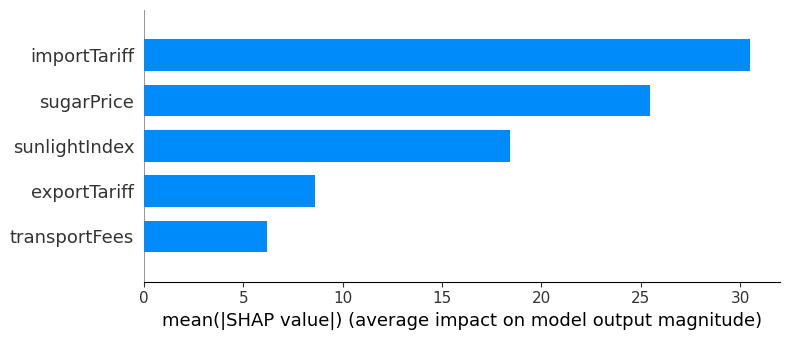

In [11]:
shap.summary_plot(
    shap_values_clean,
    X_df,
    plot_type="bar"
)

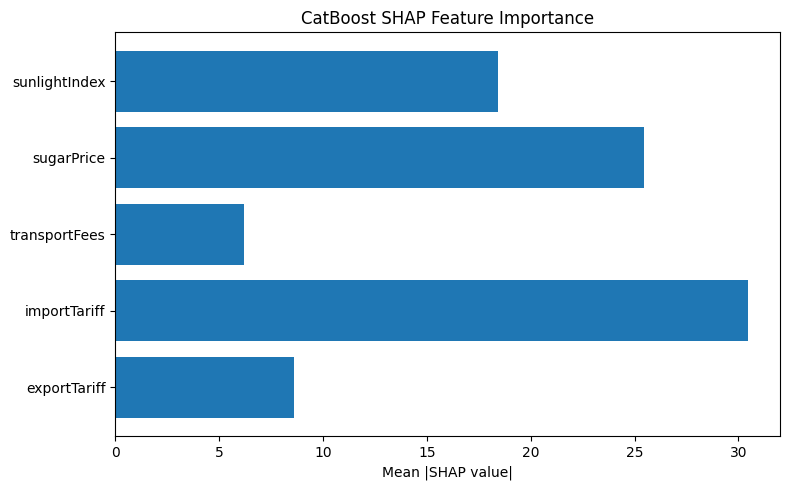

In [10]:
import numpy as np
import matplotlib.pyplot as plt

mean_abs_shap = np.abs(shap_values_clean).mean(axis=0)

plt.figure(figsize=(8, 5))
plt.barh(driver_cols, mean_abs_shap)
plt.xlabel("Mean |SHAP value|")
plt.title("CatBoost SHAP Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

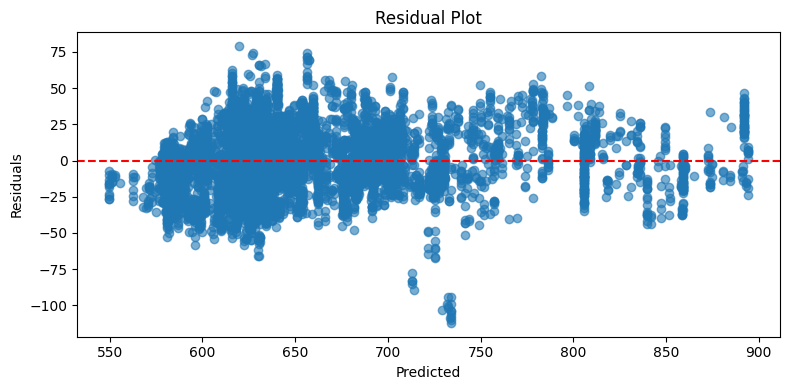

In [12]:
import matplotlib.pyplot as plt

residuals = y_test - cat.predict(X_test)

plt.figure(figsize=(8,4))
plt.scatter(cat.predict(X_test), residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.tight_layout()
plt.show()

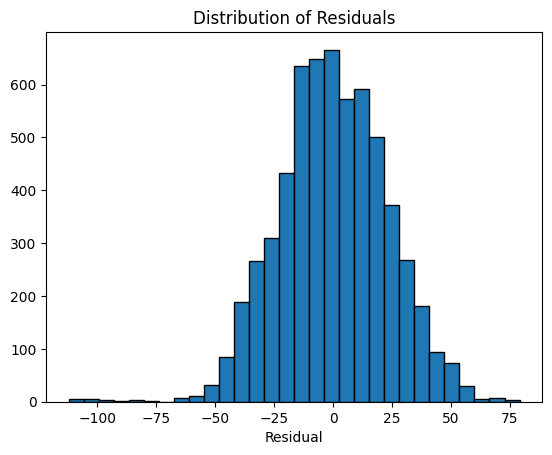

In [15]:
plt.hist(residuals, bins=30, edgecolor='black')
plt.xlabel("Residual")
plt.title("Distribution of Residuals")
plt.show()

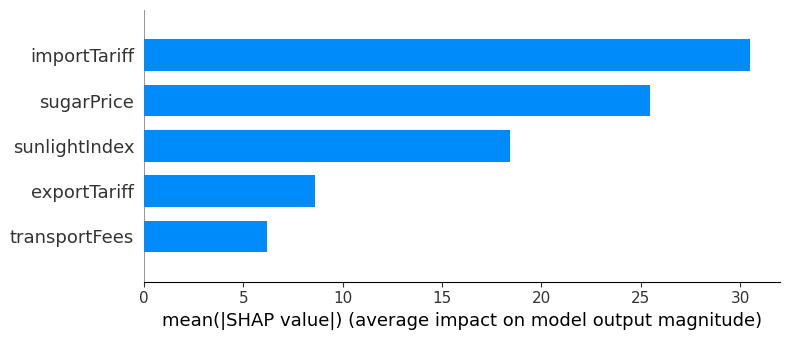

In [16]:
shap.summary_plot(shap_values_clean, X_df, plot_type="bar")

In [27]:
import numpy as np
np.float = float  # <- patch first

Plotting SHAP scatter for sunlightIndex


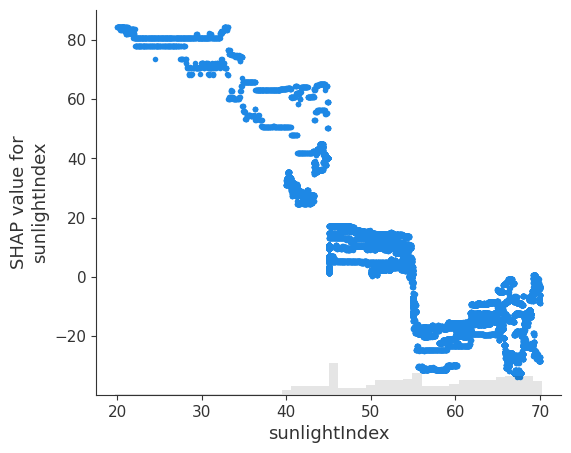

Plotting SHAP scatter for sugarPrice


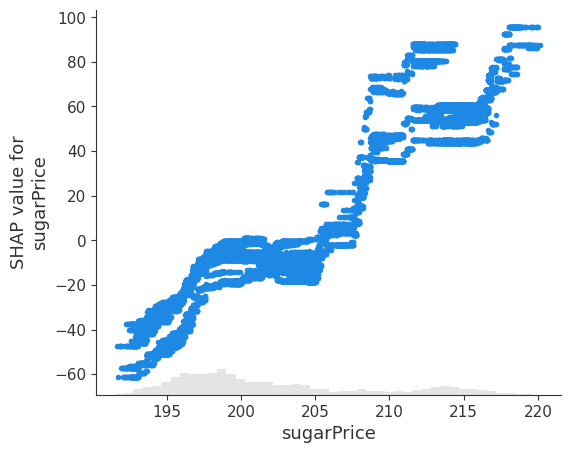

Plotting SHAP scatter for transportFees


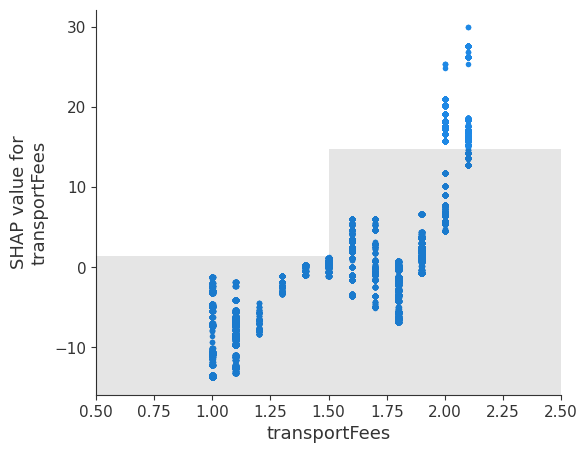

Plotting SHAP scatter for importTariff


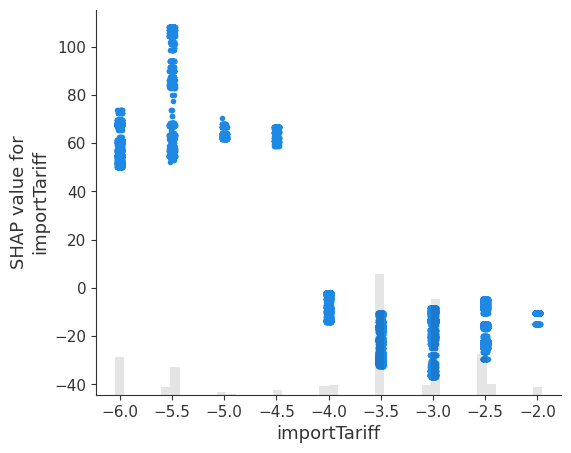

Plotting SHAP scatter for exportTariff


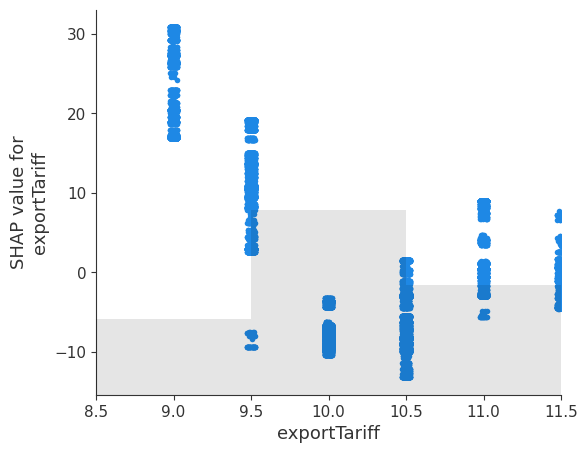

In [28]:


import shap

# convert DataFrame to numpy
X_array = X_df.values

# build Explanation object
explanation = shap.Explanation(
    values=shap_values_clean,
    base_values=np.mean(y_train),
    data=X_array,
    feature_names=driver_cols
)

# plot SHAP scatter per feature
for i, feature in enumerate(driver_cols):
    print(f"Plotting SHAP scatter for {feature}")
    shap.plots.scatter(explanation[:, i])

Plotting SHAP scatter for sunlightIndex


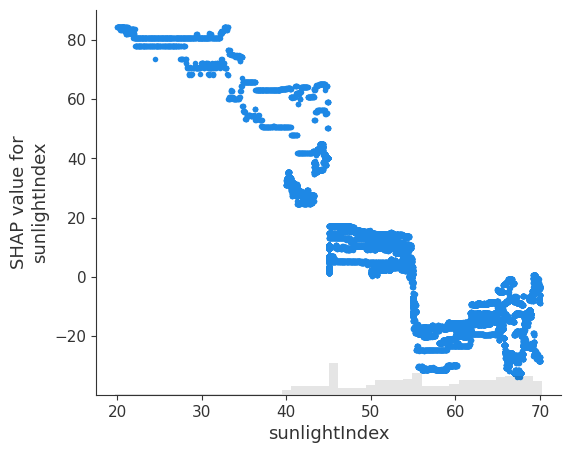

Plotting SHAP scatter for sugarPrice


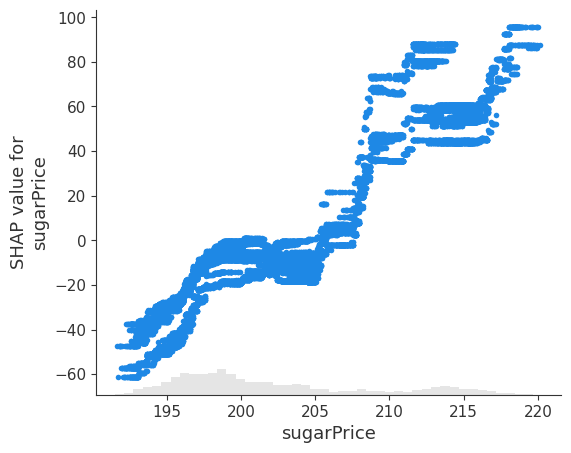

Plotting SHAP scatter for transportFees


AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

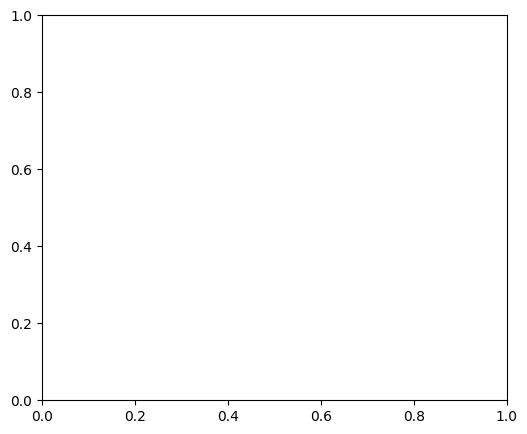

In [24]:
for i, feature in enumerate(driver_cols):
    print(f"Plotting SHAP scatter for {feature}")
    shap.plots.scatter(explanation[:, i])

In [33]:
df['bid_price_1'] - df['bidPrice']

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,...,ask_volume_3,mid_price,profit_and_loss,bidPrice,askPrice,transportFees,exportTariff,importTariff,sugarPrice,sunlightIndex
0,1,0,VOLCANIC_ROCK,10515.0,143.0,10514.0,57.0,NaN,NaN,10517,...,NaN,10516.0,0.0,627.0,628.5,1.0,9.0,-3.0,200.000000,60.00
1,1,0,PICNIC_BASKET1,58705.0,12.0,58704.0,27.0,NaN,NaN,58716,...,NaN,58710.5,0.0,627.0,628.5,1.0,9.0,-3.0,200.000000,60.00
2,1,0,PICNIC_BASKET2,30252.0,12.0,30251.0,27.0,NaN,NaN,30258,...,NaN,30255.0,0.0,627.0,628.5,1.0,9.0,-3.0,200.000000,60.00
3,1,0,VOLCANIC_ROCK_VOUCHER_9500,1015.0,12.0,NaN,NaN,NaN,NaN,1017,...,NaN,1016.0,0.0,627.0,628.5,1.0,9.0,-3.0,200.000000,60.00
4,1,0,VOLCANIC_ROCK_VOUCHER_9750,766.0,12.0,NaN,NaN,NaN,NaN,767,...,NaN,766.5,0.0,627.0,628.5,1.0,9.0,-3.0,200.000000,60.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449995,3,999900,JAMS,6446.0,96.0,6445.0,175.0,NaN,NaN,6447,...,NaN,6446.5,0.0,797.0,798.5,1.7,9.5,-5.5,212.174157,54.99
449996,3,999900,CROISSANTS,4295.0,148.0,NaN,NaN,NaN,NaN,4296,...,NaN,4295.5,0.0,797.0,798.5,1.7,9.5,-5.5,212.174157,54.99
449997,3,999900,VOLCANIC_ROCK_VOUCHER_9500,421.0,20.0,NaN,NaN,NaN,NaN,422,...,NaN,421.5,0.0,797.0,798.5,1.7,9.5,-5.5,212.174157,54.99
449998,3,999900,VOLCANIC_ROCK,9920.0,137.0,9919.0,69.0,NaN,NaN,9921,...,NaN,9920.5,0.0,797.0,798.5,1.7,9.5,-5.5,212.174157,54.99


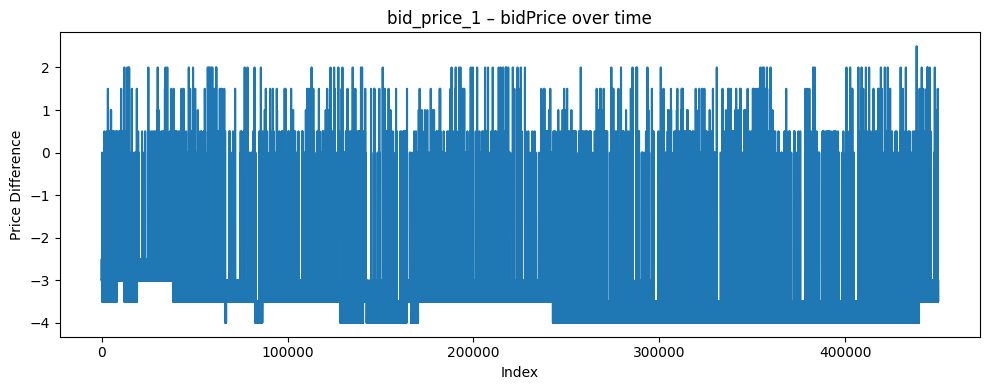

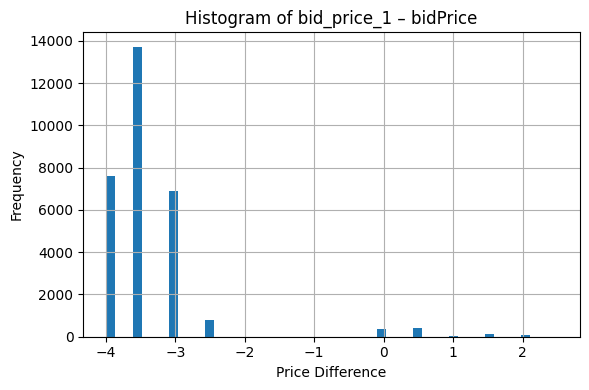

In [34]:
import matplotlib.pyplot as plt

# 1. Compute the difference
df_mac['diff'] = df_mac['bid_price_1'] - df_mac['bidPrice']

# 2a. Line‐plot of the difference over your index (e.g. time or row number)
df_mac['diff'].plot(figsize=(10,4), title='bid_price_1 – bidPrice over time')
plt.xlabel('Index')
plt.ylabel('Price Difference')
plt.tight_layout()
plt.show()

# 2b. If you meant a histogram of “hits” (i.e. the distribution of that difference):
df_mac['diff'].hist(bins=50, figsize=(6,4))
plt.title('Histogram of bid_price_1 – bidPrice')
plt.xlabel('Price Difference')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

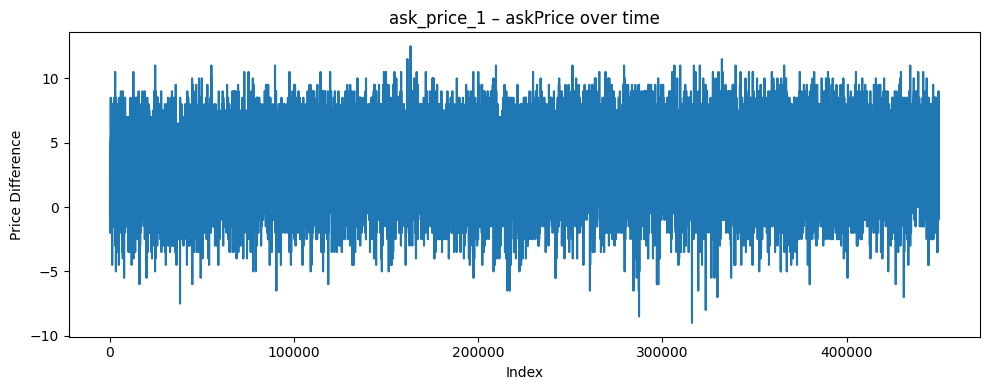

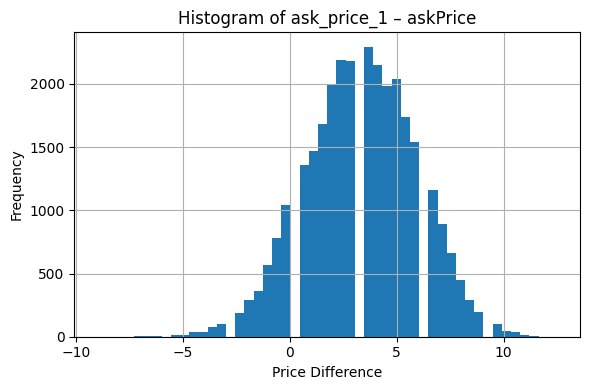

In [45]:
import matplotlib.pyplot as plt

# 1. Compute the difference
df_mac['diff'] = df_mac['ask_price_1'].shift(1)- df_mac['askPrice']

# 2a. Line‐plot of the difference over your index (e.g. time or row number)
df_mac['diff'].plot(figsize=(10,4), title='ask_price_1 – askPrice over time')
plt.xlabel('Index')
plt.ylabel('Price Difference')
plt.tight_layout()
plt.show()

# 2b. If you meant a histogram of “hits” (i.e. the distribution of that difference):
df_mac['diff'].hist(bins=50, figsize=(6,4))
plt.title('Histogram of ask_price_1 – askPrice')
plt.xlabel('Price Difference')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [44]:
df_mac.head()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,...,mid_price,profit_and_loss,bidPrice,askPrice,transportFees,exportTariff,importTariff,sugarPrice,sunlightIndex,diff
6,1,0,MAGNIFICENT_MACARONS,624.0,20.0,622.0,12.0,617.0,23.0,631,...,627.5,0.0,627.0,628.5,1.0,9.0,-3.0,200.000000,60.00,2.5
29,1,100,MAGNIFICENT_MACARONS,627.0,14.0,625.0,12.0,620.0,21.0,634,...,630.5,0.0,630.0,631.5,1.0,9.0,-3.0,200.098445,60.00,2.5
41,1,200,MAGNIFICENT_MACARONS,627.0,10.0,625.0,15.0,620.0,21.0,634,...,630.5,0.0,630.0,631.5,1.0,9.0,-3.0,200.103915,60.00,2.5
47,1,300,MAGNIFICENT_MACARONS,629.0,14.0,627.0,14.0,622.0,26.0,636,...,632.5,0.0,632.0,633.5,1.0,9.0,-3.0,200.352462,60.01,2.5
73,1,400,MAGNIFICENT_MACARONS,628.0,18.0,625.0,16.0,620.0,26.0,635,...,631.5,0.0,630.5,632.0,1.0,9.0,-3.0,200.201545,60.01,3.0


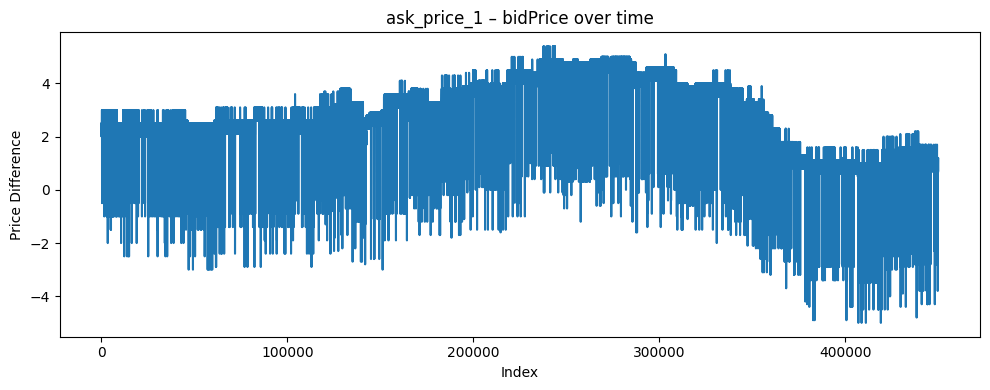

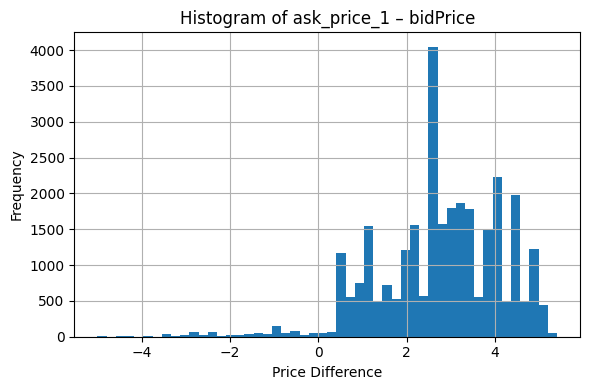

In [49]:
import matplotlib.pyplot as plt

# 1. Compute the difference
df_mac['diff'] = -df_mac['bid_price_1']+ (df_mac['askPrice']+df_mac['transportFees']+df_mac['importTariff'])

# 2a. Line‐plot of the difference over your index (e.g. time or row number)
df_mac['diff'].plot(figsize=(10,4), title='ask_price_1 – bidPrice over time')
plt.xlabel('Index')
plt.ylabel('Price Difference')
plt.tight_layout()
plt.show()

# 2b. If you meant a histogram of “hits” (i.e. the distribution of that difference):
df_mac['diff'].hist(bins=50, figsize=(6,4))
plt.title('Histogram of ask_price_1 – bidPrice')
plt.xlabel('Price Difference')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()